In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, Imputer,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.decomposition import PCA
import xgboost
import lightgbm as lg
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.options.display.float_format = '{:.2f}'.format

#df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
#plt.xlabel('Days Employment');

# The Below Function Will be Used Later In the Notebook

## The below class was borrowed from the sample notebook 

In [2]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## The following function will help us load the train dataset. 
* We have engineered  6 features here

In [3]:
def load_train():
    df_train = pd.read_csv('application_train.csv')
    df_train.index = df_train['SK_ID_CURR']
    
    #Converting days to years and removing outliers
    df_train[df_train.columns[df_train.columns.str.contains('DAYS')]] = abs(df_train[df_train.columns[df_train.columns.str.contains('DAYS')]]).replace(365243, np.nan)/365  
    
    #Naimesh Features
    df_train['income_credit_percen'] = (df_train.AMT_INCOME_TOTAL / df_train.AMT_CREDIT).replace(np.inf, 0)
    df_train['fam_member_income'] = (df_train.AMT_INCOME_TOTAL / df_train.CNT_FAM_MEMBERS).replace(np.inf, 0)
    df_train['ann_incom_percen'] =( df_train.AMT_ANNUITY / df_train.AMT_INCOME_TOTAL).replace(np.inf, 0)
    
    #Nishad Features
    df_train['new_employ_to_birth_ratio'] = (df_train.DAYS_EMPLOYED / df_train.DAYS_BIRTH).replace(np.inf, 0)
    df_train['new_credit_to_annuity'] = (df_train['AMT_CREDIT'] / df_train['AMT_ANNUITY']).replace(np.inf, 0)
    df_train['new_credit_to_goods_ratio'] = (df_train['AMT_CREDIT'] / df_train['AMT_GOODS_PRICE']).replace(np.inf, 0)
    df_train['new_car_to_birth_ratio'] = (df_train['OWN_CAR_AGE'] / df_train['DAYS_BIRTH']).replace(np.inf, 0)
    df_train['new_car_to_emp_ratio'] = (df_train['OWN_CAR_AGE'] / df_train['DAYS_EMPLOYED'] ).replace(np.inf, 0)
    df_train['new_inc_per_child'] = (df_train['AMT_INCOME_TOTAL'] / (1 + df_train['CNT_CHILDREN'])).replace(np.inf, 0)
    

    selected_features = ['SK_ID_CURR','AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
                         'EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR',
                         'NAME_CONTRACT_TYPE','NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE',
                         'income_credit_percen','fam_member_income','ann_incom_percen','new_employ_to_birth_ratio',
                         'new_credit_to_annuity','new_credit_to_goods_ratio','new_car_to_birth_ratio','new_car_to_emp_ratio',
                         'new_inc_per_child']

    
    X_train= df_train[selected_features]
    y_train = df_train['TARGET']


    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify  = y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42,stratify  = y_train)

    X_valid.index = X_valid['SK_ID_CURR']
    X_train.index = X_train['SK_ID_CURR']
    X_test.index = X_test['SK_ID_CURR']


    X_valid.drop('SK_ID_CURR', inplace = True , axis = 1)
    X_train.drop('SK_ID_CURR', inplace = True , axis = 1)
    X_test.drop('SK_ID_CURR', inplace = True , axis = 1)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

## The following function will help us transfrom the train dataset

In [4]:
def transform_train(X_train, X_valid, X_test):
    num_attribs = ['AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                   'income_credit_percen','fam_member_income','ann_incom_percen','new_employ_to_birth_ratio',
                   'new_credit_to_annuity','new_credit_to_goods_ratio','new_car_to_birth_ratio','new_car_to_emp_ratio',
                   'new_inc_per_child']

    cat_attribs = ['CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
                   'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']


    num_pipeline = Pipeline([
                            ('selector', DataFrameSelector(num_attribs)),
                            ('imputer', SimpleImputer(strategy='mean')),
                            ('std_scaler', StandardScaler()),
                           ])

    cat_pipeline = Pipeline([
                            ('selector', DataFrameSelector(cat_attribs)),
                            ('imputer', SimpleImputer(strategy='constant')),
                            ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
                            ])

    data_prep_pipeline = FeatureUnion(transformer_list=[
                                                        ("num_pipeline", num_pipeline),
                                                        ("cat_pipeline", cat_pipeline),
                                                       ])

    full_pipeline = Pipeline([("preparation", data_prep_pipeline)])

    X_trainn = pd.DataFrame(full_pipeline.fit_transform(X_train), index  = X_train.index)
    cat_cols = list(full_pipeline.named_steps['preparation'].transformer_list[1][1].named_steps['ohe'].get_feature_names(cat_attribs)) 
    X_trainn.columns = num_attribs +cat_cols
    X_validd = pd.DataFrame(full_pipeline.transform(X_valid), index = X_valid.index, columns =  num_attribs +cat_cols )
    X_testt = pd.DataFrame(full_pipeline.transform(X_test), index= X_test.index,columns =  num_attribs +cat_cols )
    
    return full_pipeline, X_trainn, X_validd, X_testt

## The following function will help us test a baseline model

In [5]:
def BaselineApproach(fitted_models,expLog, X_train,X_valid, X_test,y_train,y_test,y_valid):
    models = [LogisticRegression(n_jobs = -1, solver = 'lbfgs')]
    models_name = ['Logistic']
    ctr = 0
    p_value = 0
    for model in models:
        cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
        np.random.seed(42)
        model.fit(X_train, y_train)
        exp_name = f"Model_{models_name[ctr]}_features_{X_train.shape[1]}"
        fitted_models.append(model)
        logit_scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs  = -1)
        p_value = 0
        expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
                   [accuracy_score(y_train, model.predict(X_train)), 
                    accuracy_score(y_valid, model.predict(X_valid)),
                    accuracy_score(y_test, model.predict(X_test)),
                    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                    roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                    roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),p_value],
                    4)) 
        ctr += 1
    return logit_scores

## The below function will help us merge all the files together

In [6]:
def merge_df(X_train, X_valid, X_test, files):
    for f in files:
        X_train = X_train.merge(f, how = 'left', on = 'SK_ID_CURR')
        X_valid = X_valid.merge(f, how = 'left', on = 'SK_ID_CURR')
        X_test =  X_test.merge(f, how = 'left', on = 'SK_ID_CURR')


    X_train.fillna(0, inplace = True)
    X_valid.fillna(0, inplace = True)
    X_test.fillna(0, inplace = True)
    
    return X_train, X_valid, X_test

## The bellow function will help us aggeregate all auxilary file except the ones related to bureau.
* We have enfineered two manuel features here. There is potential to add many more for the different files
* Rest of the features are engineered via automated programming. For each field we will take the mean, sum, anc count

In [7]:
def agg_files_set(file = "", pre = ""):
    if file != "":
        df_pa = pd.read_csv(file)
        df_pa.index = df_pa['SK_ID_CURR']
        df_pa.drop(['SK_ID_PREV','SK_ID_CURR'], axis = 1, inplace = True)

        #Individual File Feature Will Go Here
        if file == 'previous_application.csv':
            df_pa['AppToCredit'] =  (df_pa.AMT_APPLICATION/df_pa.AMT_CREDIT).replace(np.inf, 0)
            df_pa['DownToCredit'] = (df_pa.AMT_DOWN_PAYMENT/df_pa.AMT_CREDIT).replace(np.inf, 0)
        
        
        numcols = df_pa.select_dtypes(exclude= 'object').columns
        catcols = df_pa.select_dtypes(include= 'object').columns
        
        num = df_pa[numcols]
        cat = df_pa[catcols]


        num = num.groupby('SK_ID_CURR').agg([np.sum, np.mean,'count'])  
        num.columns = num.columns.map('_'.join)
        mdl = StandardScaler().fit(num)
        num = pd.DataFrame(mdl.transform(num),index = num.index, columns = num.columns)

        if len(catcols) != 0:
            
            catt = SimpleImputer(strategy='constant').fit_transform(cat)
            mdl = OneHotEncoder().fit(catt)
            cat = pd.DataFrame(mdl.transform(catt).toarray(), index = cat.index, columns = list(mdl.get_feature_names(catcols)))
            cat = cat.groupby('SK_ID_CURR').agg(np.mean)
            final = num.merge(cat, how = 'left', on = 'SK_ID_CURR')
        else:
            final = num
        
        final = final.add_prefix(pre)
        return final
    return "No File"


## The below function will help us aggeregate the bureau files

In [8]:
def bureau():
    bur_bal = pd.read_csv('bureau_balance.csv')
    bur_bal = pd.get_dummies(bur_bal)
    bur_bal = bur_bal.groupby('SK_ID_BUREAU').agg([np.mean,'count',sum])
    bur_bal.columns = bur_bal.columns.map('_'.join)

    bur = pd.read_csv('bureau.csv')
    bur = pd.get_dummies(bur)
    bur = bur.merge(bur_bal, how= 'left', on = 'SK_ID_BUREAU')
    bur.drop('SK_ID_BUREAU', inplace = True, axis = 1)
    bur = bur.groupby('SK_ID_CURR').agg([np.sum, np.mean,'count'])
    bur.columns = bur.columns.map('_'.join)
    bur = bur.add_prefix('BU_BA')
    return bur


# Loading Train Dataset & Splitting Into Train Valid & Test

In [9]:
fitted_models = []
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                               "Train AUC", 
                               "Valid AUC",
                               "Test  AUC",
                               "P_Value"
                              ])

#Loading & Transforming Train
X_train, y_train, X_valid, y_valid, X_test, y_test = load_train()


## Transforming Train, Valid, & Test and Getting Baseline Score

In [10]:
full_pipeline, X_train, X_valid, X_test = transform_train(X_train, X_valid, X_test)

#BaselIne Model
logit_scores_baseline = BaselineApproach(fitted_models,expLog, X_train,X_valid, X_test,y_train,y_test,y_valid)
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,Model_Logistic_features_57,0.92,0.92,0.92,0.74,0.74,0.75,0.00


# Adding All Auxilary Files To the Train Test & Valid Set

## Auxilary Files Have Been Aggereated with metrics [Mean, Count, SUM]

In [11]:
#Adding All files to X_train

df_pv_app = agg_files_set('previous_application.csv','PA_')
df_pos_app = agg_files_set('POS_CASH_balance.csv','POS_')
df_ins_pay = agg_files_set('installments_payments.csv','IP_') 
df_credit_pay = agg_files_set('credit_card_balance.csv', 'CC_')
df_bureau = bureau()

lst = [df_pv_app,df_pos_app,df_ins_pay, df_credit_pay,df_bureau]
X_train, X_valid, X_test = merge_df(X_train, X_valid, X_test, lst)


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\ipykernel_launch

# Train light GBM model on all auxilary files

The best score was dict_items([('training', {'binary_logloss': 0.19903190543245752, 'auc': 0.8918160474632701}), ('valid_1', {'binary_logloss': 0.23824928238971838, 'auc': 0.7830448701807333}), ('valid_2', {'binary_logloss': 0.23834743559471944, 'auc': 0.782486219321622})]) 


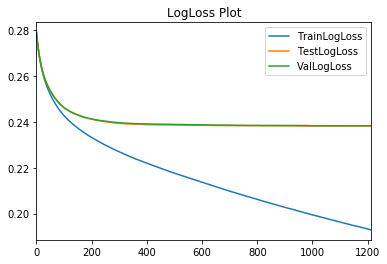

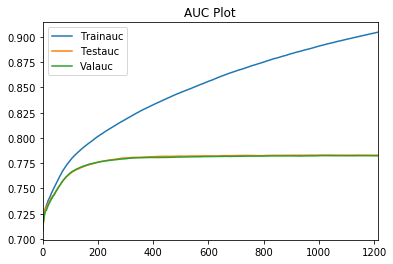

In [12]:
params = {
    'n_estimators'  : 5000
    ,'learning_rate' : 0.025
    ,'n_jobs'  : -1
    }


lg_model =lg.LGBMClassifier(**params)
lg_model.fit(X_train, y_train
        ,eval_set=[(X_train, y_train), (X_test,y_test),(X_valid, y_valid)]
        ,eval_metric=['logloss','auc']
        ,early_stopping_rounds = 200   
        ,verbose=False )

evals_result = lg_model.evals_result_
evals = pd.DataFrame(evals_result['training']['binary_logloss'], columns  = ['TrainLogLoss'])
evals['TestLogLoss'] = evals_result['valid_1']['binary_logloss']
evals['ValLogLoss'] = evals_result['valid_2']['binary_logloss']
evals.plot(title = "LogLoss Plot")
    

auc = pd.DataFrame(evals_result['training']['auc'], columns  = ['Trainauc'])
auc['Testauc'] = evals_result['valid_1']['auc']
auc['Valauc'] = evals_result['valid_2']['auc']
auc.plot(title = "AUC Plot")

print(f"The best score was {lg_model.best_score_.items()} ")

## 78% Valid & Test AUC Not Bad

In [13]:

exp_name = "LGBM - All Files - No Feature Selection - No parameter Tuning -  Many Feature Engineering"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
           [accuracy_score(y_train, lg_model.predict(X_train)), 
            accuracy_score(y_valid, lg_model.predict(X_valid)),
            accuracy_score(y_test, lg_model.predict(X_test)),
            roc_auc_score(y_train, lg_model.predict_proba(X_train)[:, 1]),
            roc_auc_score(y_valid, lg_model.predict_proba(X_valid)[:, 1]),
            roc_auc_score(y_test, lg_model.predict_proba(X_test)[:, 1]),0],
            4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,Model_Logistic_features_57,0.92,0.92,0.92,0.74,0.74,0.75,0.00
1,LGBM - All Files - No Feature Selection - No p...,0.92,0.92,0.92,0.89,0.78,0.78,0.00


# Lets See if We can Improve accuracy By selecting an lower set of features

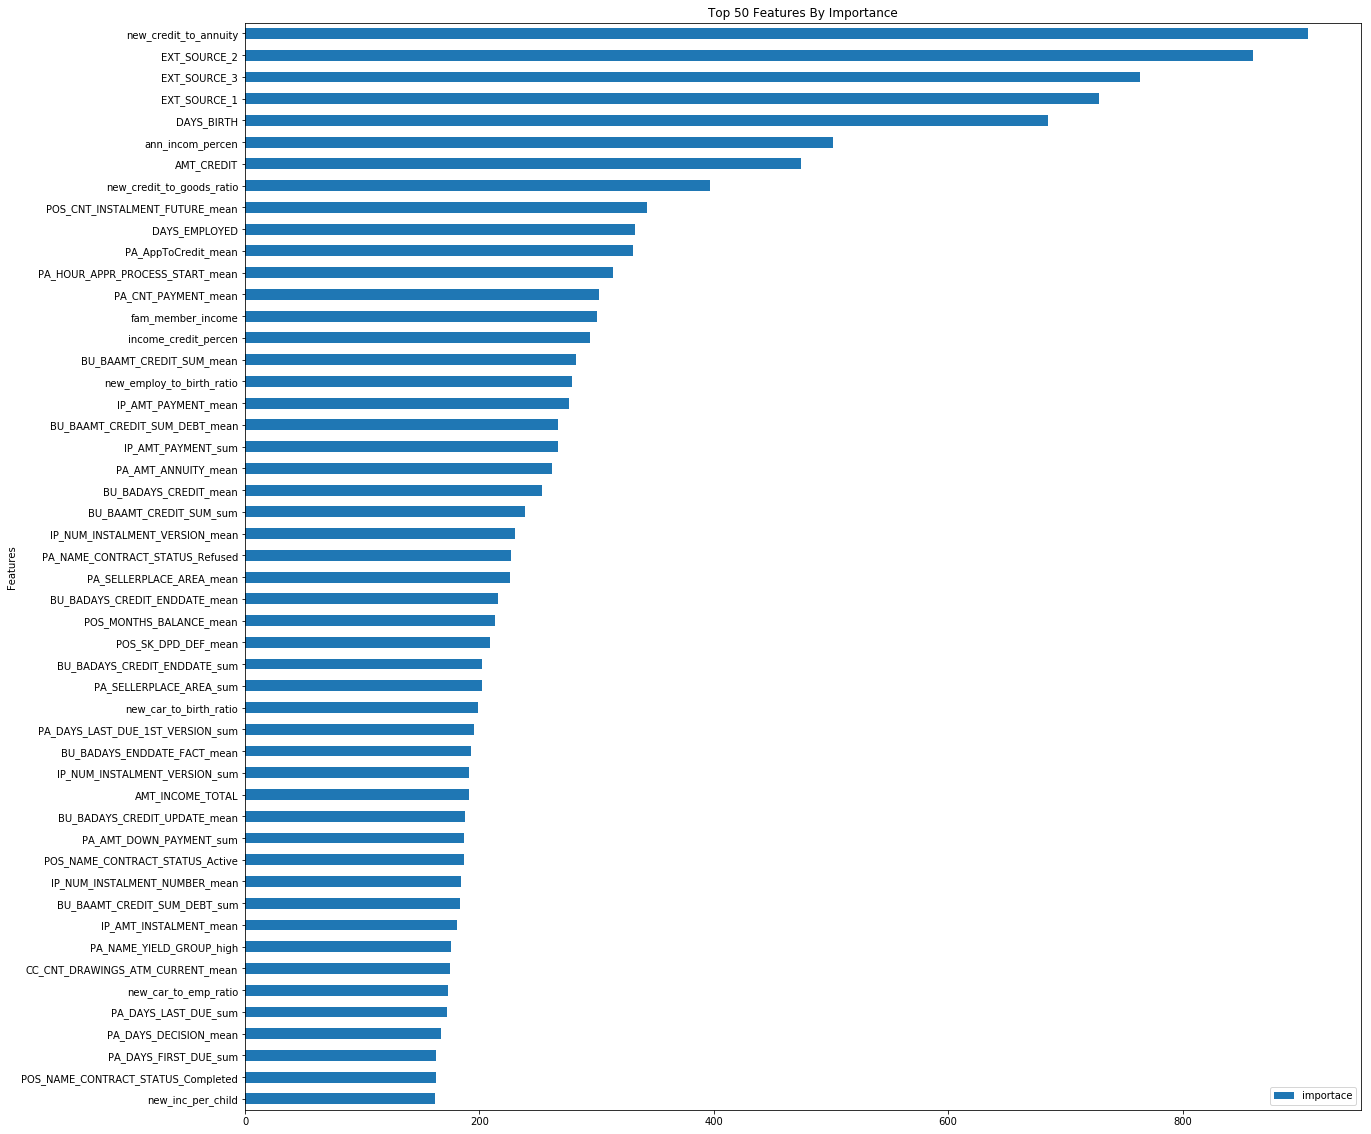

In [14]:
imp = pd.DataFrame(X_train.columns , columns = ['Features'])
imp['importace'] = lg_model.feature_importances_
imp = imp.sort_values(by = 'importace', ascending = False)
imp[imp['importace'] > 0][0:50].sort_values(by = 'importace', ascending = True).plot(kind = 'barh' , x = 'Features', y ='importace', figsize=(20,20), title = "Top 50 Features By Importance")

## There are lots of features, lets itterate 25 features at a time and compare AUC

#### 300 seems to be the magic number  after which metrics stop improving

In [15]:
params = {
    'n_estimators'  : 100,
    'learning_rate' : 0.1,
    }
lg_model =lg.LGBMClassifier(**params)
scores = []
numfeatures = []
for x  in range(1,20):
    x  = x * 25
    features = imp['Features'][0:x].values
    train  = X_train[features]
    valid = X_valid[features]
    test = X_test[features]
    lg_model.fit(train,y_train,
        eval_set = [(valid,y_valid)],
        eval_metric=['logloss','auc']
        ,early_stopping_rounds=10
        ,verbose = False)
    scores.append(lg_model.best_score_['valid_0']['auc'])
    numfeatures.append(x)
    scores_pa = lg_model.predict_proba(test)[:,1]
    roc = roc_auc_score(y_test, scores_pa)
    print('Best score for valid is ' + str(round(lg_model.best_score_['valid_0']['auc'],4)) + ' on top ' + str(x) + ' features by importance')
    print('Best score for test is ' + str(round(roc,4)) + ' on top ' + str(x) + ' features by importance\n')
    

Best score for valid is 0.7682 on top 25 features by importance
Best score for test is 0.765 on top 25 features by importance

Best score for valid is 0.7709 on top 50 features by importance
Best score for test is 0.7713 on top 50 features by importance

Best score for valid is 0.7739 on top 75 features by importance
Best score for test is 0.7739 on top 75 features by importance

Best score for valid is 0.7723 on top 100 features by importance
Best score for test is 0.772 on top 100 features by importance

Best score for valid is 0.776 on top 125 features by importance
Best score for test is 0.775 on top 125 features by importance

Best score for valid is 0.7762 on top 150 features by importance
Best score for test is 0.775 on top 150 features by importance

Best score for valid is 0.7786 on top 175 features by importance
Best score for test is 0.7784 on top 175 features by importance

Best score for valid is 0.7775 on top 200 features by importance
Best score for test is 0.7783 on top

## Retraining the model on the best 300 features

In [16]:
params = {
    'n_estimators'  : 5000
    ,'learning_rate' : 0.025
    ,'n_jobs'  : -1
    }

features = imp['Features'][0:300].values
train  = X_train[features]
valid = X_valid[features]
test = X_test[features]

lg_model =lg.LGBMClassifier(**params)
lg_model.fit(train, y_train
        ,eval_set=[(train, y_train), (test,y_test),(valid, y_valid)]
        ,eval_metric=['logloss','auc']
        ,early_stopping_rounds = 200   
        ,verbose=False )



exp_name = "LGBM - All Files - 300 Feature - No parameter Tuning -  Many Feature Engineering"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
           [accuracy_score(y_train, lg_model.predict(train)), 
            accuracy_score(y_valid, lg_model.predict(valid)),
            accuracy_score(y_test, lg_model.predict(test)),
            roc_auc_score(y_train, lg_model.predict_proba(train)[:, 1]),
            roc_auc_score(y_valid, lg_model.predict_proba(valid)[:, 1]),
            roc_auc_score(y_test, lg_model.predict_proba(test)[:, 1]),0],
            4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,Model_Logistic_features_57,0.92,0.92,0.92,0.74,0.74,0.75,0.00
1,LGBM - All Files - No Feature Selection - No p...,0.92,0.92,0.92,0.89,0.78,0.78,0.00
2,LGBM - All Files - 300 Feature - No parameter ...,0.92,0.92,0.92,0.89,0.78,0.78,0.00


# Lets see if we can improve the score by hyper parameter tuning
* We did not want to use grid search as that would take a very long time. So we opted for baysian hyper parameter tuning via the hyperopt package

In [17]:
features = imp['Features'][0:300].values
train  = X_train[features]
valid = X_valid[features]
test = X_test[features]
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'learning_rate' : '{:.3f}'.format(params['learning_rate']),
        'min_child_weight' : int(params['min_child_weight']),
        'subsample' : '{:.3f}'.format(params['subsample']),  
           }
    
    clf =lg.LGBMClassifier(
        n_estimators=500,
        n_jobs=-1,
        **params
    )
    
    gbm_model = clf.fit(train , y_train
                ,eval_set=[(valid, y_valid)]
                ,eval_metric=['logloss','auc']
                ,early_stopping_rounds = 50
                ,verbose=False)
    
    predictions = gbm_model.predict_proba(valid)[:, 1]
    score = roc_auc_score(y_valid, predictions)
    
    return {'loss': 1-score, 'status': STATUS_OK}

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0,0.1),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
     'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'reg_alpha': hp.quniform('reg_alpha', 0.0, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 0.0, 1, 0.1),
    
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)
print(best)

100%|██████████| 30/30 [07:54<00:00, 16.93s/it, best loss: 0.2156171096055386]
{'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 5.0, 'min_child_weight': 4.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.0, 'subsample': 1.0}


# Retraining With Best Parameter & Optimal Feature

In [18]:
best['max_depth'] = int(best['max_depth'])
features = imp['Features'][0:300].values
train  = X_train[features]
valid = X_valid[features]
test = X_test[features]

lg_model =lg.LGBMClassifier(**best, n_estimators=5000)

lg_model.fit(train, y_train
        ,eval_set=[(valid, y_valid)]
        ,eval_metric=['logloss','auc']
        ,early_stopping_rounds = 200   
        ,verbose=False )

exp_name = "LGBM - All Files - 300 Feature - Parameter Tuned -  Many Feature Engineering"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
           [accuracy_score(y_train, lg_model.predict(train)), 
            accuracy_score(y_valid, lg_model.predict(valid)),
            accuracy_score(y_test, lg_model.predict(test)),
            roc_auc_score(y_train, lg_model.predict_proba(train)[:, 1]),
            roc_auc_score(y_valid, lg_model.predict_proba(valid)[:, 1]),
            roc_auc_score(y_test, lg_model.predict_proba(test)[:, 1]),0],
            4)) 

expLog


,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,Model_Logistic_features_57,0.92,0.92,0.92,0.74,0.74,0.75,0.00
1,LGBM - All Files - No Feature Selection - No p...,0.92,0.92,0.92,0.89,0.78,0.78,0.00
2,LGBM - All Files - 300 Feature - No parameter ...,0.92,0.92,0.92,0.89,0.78,0.78,0.00
3,LGBM - All Files - 300 Feature - Parameter Tun...,0.93,0.92,0.92,0.88,0.79,0.78,0.00


# Testing our model on the application_test data. 

In [19]:
features = imp['Features'][0:300].values
fitted_models = []
fitted_models.append(lg_model)
def test_sub(full_pipeline,files,fitted_models, features):
    df_test = pd.read_csv('application_test.csv')
    df_test.index = df_test['SK_ID_CURR']    
    
    #converting days to years and removing outliers
    df_test[df_test.columns[df_test.columns.str.contains('DAYS')]] = abs(df_test[df_test.columns[df_test.columns.str.contains('DAYS')]]).replace(365243, np.nan)/365 
    
    #Naimesh Features
    df_test['income_credit_percen'] = (df_test.AMT_INCOME_TOTAL / df_test.AMT_CREDIT).replace(np.inf, 0)
    df_test['fam_member_income'] = (df_test.AMT_INCOME_TOTAL / df_test.CNT_FAM_MEMBERS).replace(np.inf, 0)
    df_test['ann_incom_percen'] =( df_test.AMT_ANNUITY / df_test.AMT_INCOME_TOTAL).replace(np.inf, 0)
    
    #Nishad Features
    df_test['new_employ_to_birth_ratio'] = (df_test.DAYS_EMPLOYED / df_test.DAYS_BIRTH).replace(np.inf, 0)
    df_test['new_credit_to_annuity'] = (df_test['AMT_CREDIT'] / df_test['AMT_ANNUITY']).replace(np.inf, 0)
    df_test['new_credit_to_goods_ratio'] = (df_test['AMT_CREDIT'] / df_test['AMT_GOODS_PRICE']).replace(np.inf, 0)
    df_test['new_car_to_birth_ratio'] = (df_test['OWN_CAR_AGE'] / df_test['DAYS_BIRTH']).replace(np.inf, 0)
    df_test['new_car_to_emp_ratio'] = (df_test['OWN_CAR_AGE'] / df_test['DAYS_EMPLOYED'] ).replace(np.inf, 0)
    df_test['new_inc_per_child'] = (df_test['AMT_INCOME_TOTAL'] / (1 + df_test['CNT_CHILDREN'])).replace(np.inf, 0)
    
    
    
    num_attribs = ['AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                   'income_credit_percen','fam_member_income','ann_incom_percen','new_employ_to_birth_ratio',
                   'new_credit_to_annuity','new_credit_to_goods_ratio','new_car_to_birth_ratio','new_car_to_emp_ratio',
                   'new_inc_per_child']

    cat_attribs = ['CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
                   'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']

    

    tst_ind = df_test['SK_ID_CURR']
    test = pd.DataFrame(full_pipeline.transform(df_test), index = tst_ind)
    cat_cols = list(full_pipeline.named_steps['preparation'].transformer_list[1][1].named_steps['ohe'].get_feature_names(cat_attribs)) 
    test.columns = num_attribs +cat_cols
    
    
    for f in files:
        test = test.merge(f, how = 'left', on = 'SK_ID_CURR')
    
    
    test.fillna(0,inplace = True)
    test = test[features]
    pred = fitted_models[0].predict_proba(test)[:,1]
    sub = pd.DataFrame(tst_ind)
    sub['TARGET'] = pred
    sub.to_csv('submission.csv', index = False)


In [20]:
test_sub(full_pipeline,lst,fitted_models,features)

In [21]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "LightGBM - All Files - 300 Features With Opt Parameters & Nishad Features v2"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.31M [00:00<?, ?B/s]
  6%|5         | 80.0k/1.31M [00:00<00:01, 795kB/s]
 72%|#######2  | 968k/1.31M [00:00<00:00, 1.09MB/s]
100%|##########| 1.31M/1.31M [00:02<00:00, 490kB/s]


## Below are our kaggle submission results

In [24]:
!kaggle competitions submissions home-credit-default-risk

fileName           date                 description                                                                   status    publicScore  privateScore  
-----------------  -------------------  ----------------------------------------------------------------------------  --------  -----------  ------------  
submission.csv     2019-04-18 04:12:52  LightGBM - All Files - 300 Features With Opt Parameters & Nishad Features v2  complete  0.77944      0.77962       
submission.csv     2019-04-18 03:39:34  LightGBM - All Files - 250 Features With Opt Parameters & Nishad Features v2  complete  0.78111      0.77847       
submission.csv     2019-04-18 02:42:39  LightGBM - All Files - 250 Features With Opt Parameters & Nishad Features v2  complete  0.77951      0.77692       
submission.csv     2019-04-18 01:02:07  LightGBM - All Files - 300 Features With Opt Parameters v1                    complete  0.76316      0.76709       
submission.csv     2019-04-18 01:01:38  XGBOOST - All Files - No

# The Most Important features

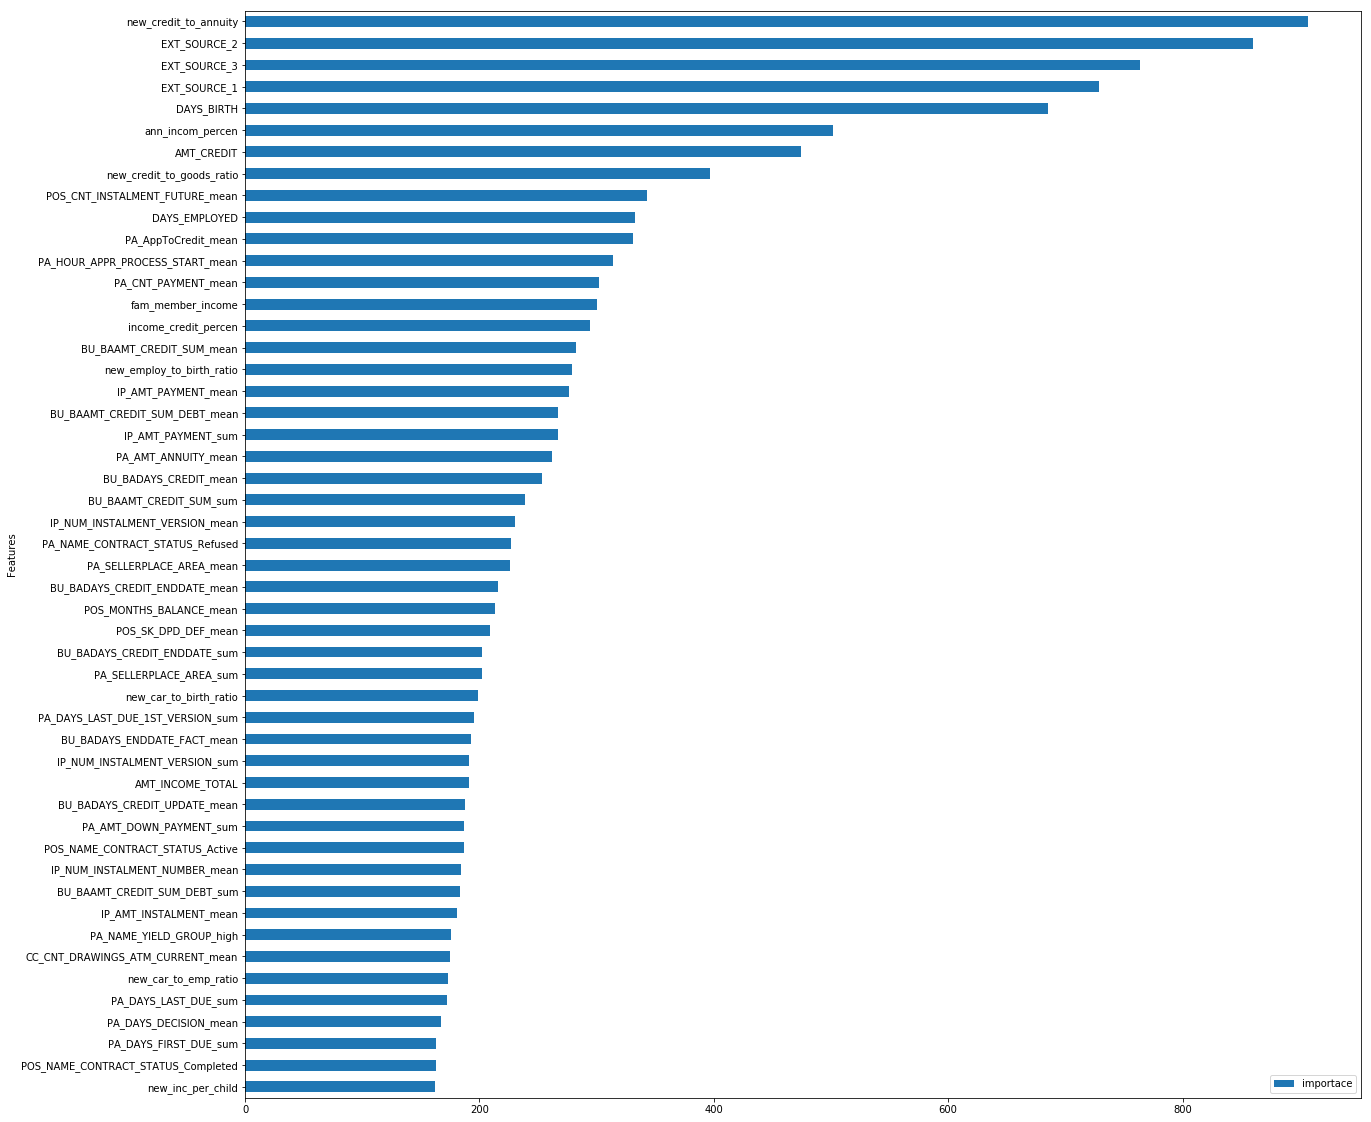

In [23]:
imp[imp['importace'] > 0][0:50].sort_values(by = 'importace', ascending = True).plot(kind = 'barh' , x = 'Features', y ='importace', figsize=(20,20))